**PyTorch Computer Vision Workflow**

This outline details the steps for a complete computer vision project using PyTorch, from data loading to model evaluation and saving.

| Step | Topic | Contents |
| :--- | :--- | :--- |
| **0** | **Computer Vision Libraries in PyTorch** | PyTorch has a bunch of built-in helpful computer vision libraries; let's check them out. |
| **1** | **Load Data** | To practice computer vision, we'll start with some images of different pieces of clothing from **FashionMNIST**. |
| **2** | **Prepare Data** | We've got some images; let's load them in with a PyTorch **`DataLoader`** so we can use them with our training loop. |
| **3** | **Model 0: Building a Baseline Model** | Here we'll create a multi-class classification model to learn patterns in the data. We'll also choose a **loss function**, **optimizer**, and build a **training loop**. |
| **4** | **Making Predictions and Evaluating Model 0** | Let's make some predictions with our baseline model and evaluate them. |
| **5** | **Setup Device Agnostic Code for Future Models** | It's best practice to write **device-agnostic code** (CPU/GPU), so let's set it up. |
| **6** | **Model 1: Adding Non-linearity** | Experimenting is a large part of machine learning; let's try and improve upon our baseline model by adding non-linear layers. |
| **7** | **Model 2: Convolutional Neural Network (CNN)** | Time to get computer vision specific and introduce the powerful **Convolutional Neural Network (CNN)** architecture. |
| **8** | **Comparing Our Models** | We've built three different models; let's compare them. |
| **9** | **Evaluating Our Best Model** | Let's make some predictions on random images and evaluate our best model. |
| **10** | **Making a Confusion Matrix** | A **confusion matrix** is a great way to evaluate a classification model; let's see how we can make one. |
| **11** | **Saving and Loading the Best Performing Model** | Since we might want to use our model later, let's save it and make sure it loads back in correctly. |

**Common PyTorch libraries for torchvision**

This table outlines the core modules you'll typically use for computer vision tasks in PyTorch.

| PyTorch Module | What Does It Do? |
| :--- | :--- |
| **`torchvision`** | Contains datasets, model architectures, and image transformations often used for computer vision problems. |
| **`torchvision.datasets`** | Provides many example computer vision datasets (classification, detection, etc.) and base classes for **making custom datasets**. |
| **`torchvision.models`** | Contains well-performing and commonly used **pre-trained computer vision model architectures** (like ResNet, VGG, etc.) implemented in PyTorch. |
| **`torchvision.transforms`** | Contains common functions to **preprocess, normalize, and augment images** before they are used with a model. |
| **`torch.utils.data.Dataset`** | The **base dataset class** for PyTorch. You often subclass this to handle your custom data. |
| **`torch.utils.data.DataLoader`** | Creates a **Python iterable** over a dataset, allowing for batching, shuffling, and multi-process data loading. |

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import Torchvision
import torchvision
from torchvision.transforms import ToTensor

print(torchvision.__version__)
print(torch.__version__)

0.23.0+cpu
2.8.0+cpu


*Getting fashionMINIST dataset from PyTorch*

In [2]:
from torchvision import datasets

# set up training data
train_data=datasets.FashionMNIST(
    root='data', # root directory to store data
    train=True, # training data
    download=True, # True for downloading
    transform=ToTensor(), # image comes as PIL (Python Imaging Format), we want to turn into Torch Tensor
    target_transform=None # we can transform label as well
)


# set up testing data
test_data=datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)


In [3]:
image, label=train_data[0]
print(label)

9


In [4]:
print(image.shape)
# this represent
# color_channel=1, height=28, width=28
# color_channel=1 means grayscale

torch.Size([1, 28, 28])


In [5]:
# total samples
print(len(train_data.data))
print(len(train_data.targets))
print(len(test_data.data))
print(len(test_data.targets))

# 60,000 training samples
# 10,000 testing samples

60000
60000
10000
10000


In [6]:
# class names of data
# we're working with multi-class classification
class_names=train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


*visualizing data*

torch.Size([1, 28, 28])


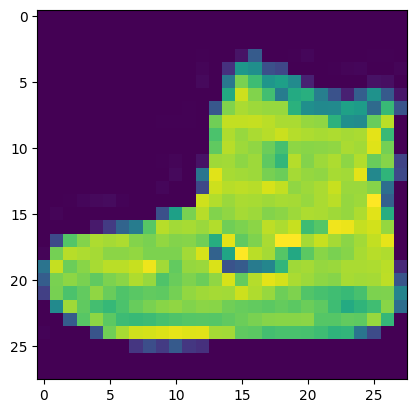

In [7]:

import matplotlib.pyplot as plt
image, label=train_data[0]
print(image.shape)
plt.imshow(image.squeeze())

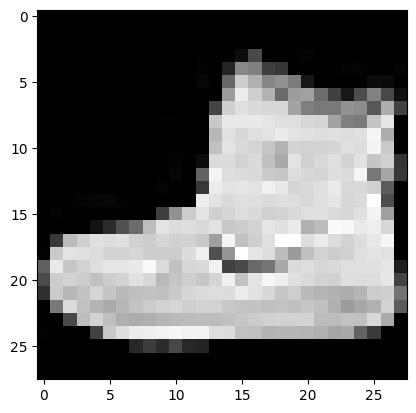

In [8]:
# Truning this image into gray-scale image
plt.imshow(image.squeeze(), cmap='gray')

*some other images*

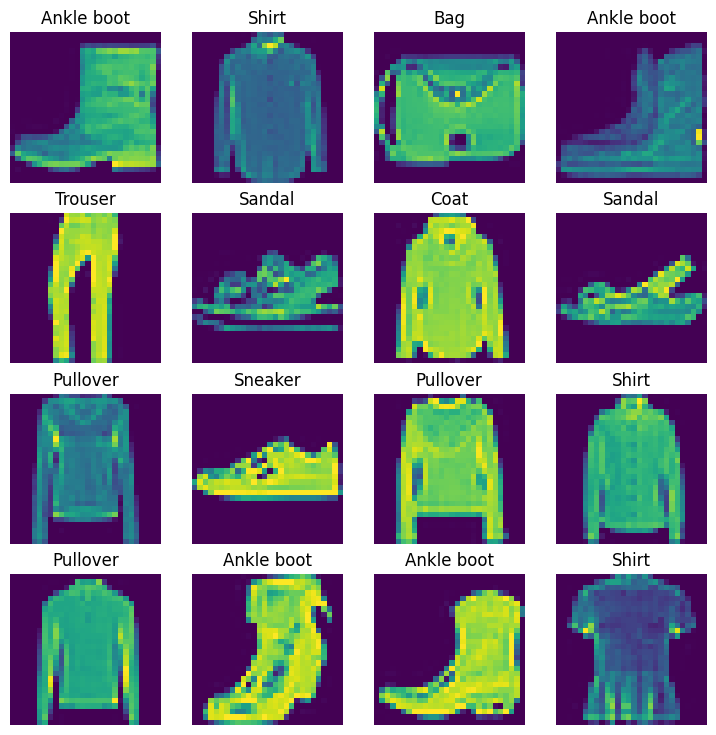

In [9]:
torch.manual_seed(42)
rows=4
cols=4
fig=plt.figure(figsize=(9,9))
for i in range(1, rows*cols+1):
    raondom_idx=torch.randint(0,len(train_data),size=(1,)).item()
    image,label=train_data[raondom_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze())
    plt.title(class_names[label])
    plt.axis(False)


**Prepare DataLoader**

`DataLoader` helps to laod the data into a Model, which then works into traing and testing model.
we can control `batch_size` with it

`from torch.utils.data import DataLoader` 

In [10]:
from torch.utils.data import DataLoader
BATCH_SIZE=32 # hyperparameter

# turning the dataset into iteratble (batches)
train_dataloader=DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)

test_dataloader=DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False # don't necessary shuffle testing data
                           )

In [11]:
print(len(train_dataloader))
print(len(test_dataloader))


1875
313


In [12]:
# let's see what inside training, testing dataloader
train_features_batch, train_labels_batch=next(iter(train_dataloader))
print(train_features_batch.shape)
print(train_labels_batch.shape)


torch.Size([32, 1, 28, 28])
torch.Size([32])


Text(0.5, 1.0, 'Shirt')

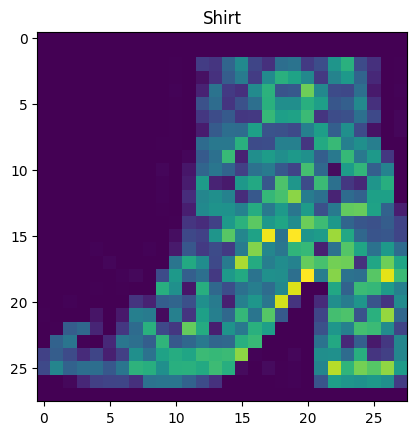

In [13]:
# getting a sample
torch.manual_seed(75)
random_indx=torch.randint(0, len(train_features_batch),size=(1,)).item()
image, labels=train_features_batch[random_indx], train_features_batch[random_indx]
plt.imshow(image.squeeze())
plt.title(class_names[label])


**Model 0: Building a Baseline model**

For making a baseline model, we'll be using simple `nn.Linear()` layers.
but before that, we need to add `nn.Faltten()` to change image tensor dimentions into feature vector

*Example of `nn.Faltten()`*

In [14]:
# working with nn.Faltten()
from torch import nn
flatten_model=nn.Flatten()
X=train_features_batch[0]
output=flatten_model(X)

print(X.shape)
print(output.shape)                

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [15]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape:int, hidden_layer:int, output_shape:int):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_layer),
            nn.Linear(in_features=hidden_layer, out_features=output_shape)
        
        )

    def forward(self, x):
        return self.layer_stack(x)
    

In [16]:
# setting agonistic device
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [17]:
model_0=FashionMNISTModelV0(input_shape=784,hidden_layer=10,output_shape=len(class_names))
model_0.to(device)

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
# downloading some of the stuffs
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get(
      "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [19]:
from helper_functions import accuracy_fn
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(), lr=0.1)

*Creating a training loop and training model on batches of data*

In [20]:
# for progress bar
from tqdm.auto import tqdm
torch.manual_seed(42)
epochs=5

for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch}--------')

    train_loss=0 # training loss

    # looping through batches
    for batch, (X,y) in enumerate(train_dataloader):
            
        model_0.train()  # model_0 training
        y_pred=model_0(X) # Forward pass
        loss=loss_fn(y_pred, y) # loss function
        train_loss+=loss # updating training loss
        optimizer.zero_grad() # zero gradient
        loss.backward() # backpropagation
        optimizer.step() # updating optimizer

        # printing how many samples have been seen
        if batch%500==0:
            print(
                f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    # total train loss
    train_loss/=len(train_dataloader)

    # Testing
    test_loss=0
    test_acc=0
    model_0.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            test_pred=model_0(X) # Forward pass
            test_loss+=loss_fn(test_pred,y) # loss
            test_acc+=accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss/=len(test_dataloader)
        test_acc/=len(test_dataloader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


c:\Users\USER\PyTorch\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0--------
Looked at 0/60000 samples
Looked at 16000/60000 samples
Looked at 32000/60000 samples
Looked at 48000/60000 samples


 20%|██        | 1/5 [00:09<00:39,  9.79s/it]


Train loss: 0.58746 | Test loss: 0.50279, Test acc: 82.32%

Epoch 1--------
Looked at 0/60000 samples
Looked at 16000/60000 samples
Looked at 32000/60000 samples
Looked at 48000/60000 samples


 40%|████      | 2/5 [00:22<00:33, 11.26s/it]


Train loss: 0.47553 | Test loss: 0.48126, Test acc: 83.34%

Epoch 2--------
Looked at 0/60000 samples
Looked at 16000/60000 samples
Looked at 32000/60000 samples
Looked at 48000/60000 samples


 60%|██████    | 3/5 [00:32<00:22, 11.05s/it]


Train loss: 0.45459 | Test loss: 0.47736, Test acc: 83.34%

Epoch 3--------
Looked at 0/60000 samples
Looked at 16000/60000 samples
Looked at 32000/60000 samples
Looked at 48000/60000 samples


 80%|████████  | 4/5 [00:41<00:10, 10.09s/it]


Train loss: 0.44221 | Test loss: 0.46229, Test acc: 83.70%

Epoch 4--------
Looked at 0/60000 samples
Looked at 16000/60000 samples
Looked at 32000/60000 samples
Looked at 48000/60000 samples


100%|██████████| 5/5 [00:50<00:00, 10.03s/it]


Train loss: 0.43556 | Test loss: 0.46884, Test acc: 83.16%



*Making a function for getting the overall accuracy of model_0*

In [21]:
torch.manual_seed(42)

def model_evaluation(model:torch.nn.Module,
                     data_loader:torch.utils.data.DataLoader,
                     loss_fn:torch.nn.Module,
                     accuracy_fn):
    
    loss=0
    acc=0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            model_pred=model(X)
            loss+=loss_fn(model_pred, y)
            acc+=accuracy_fn(y_true=y, y_pred=model_pred.argmax(dim=1))
        loss/=len(data_loader)
        acc/=len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


In [ ]:
# performance matrix for model_0
model_0_performance=model_evaluation(model=model_0,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
print(model_0_performance)


{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.46884456276893616, 'model_acc': 83.15694888178913}
